### Solving **I**nstance **D**etection from an **O**pen-**W**orld perspective (**IDOW**)
- Setting
  - Conventional Instance Detection (*CID*)
- Dataset
  - [HR-InsDet](https://drive.google.com/drive/folders/1rIRTtqKJGCTifcqJFSVvFshRb-sB0OzP) Dataset
- Notes
    1. This jupyter notebook is used to demonstrate <font color=yellow>IDOW<sub>GroundingDINO</sub></font> corresponding to Table 1 and Figure 4.
    2. We modify codes from [Shen et al., NeurIPS'23](https://github.com/insdet/instance-detection).

In [2]:
from functools import partial
import argparse
import cv2
import glob
import json
import logging
import mmcv
import os
import re
import random
import sys
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
from typing import List, Optional
from PIL import Image, ImageFile

import torch
import torch.nn as nn
from torch.nn import init
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import transforms as pth_transforms
from torchvision.ops import box_convert

sys.path.append("../dinov2-main")
from dinov2.eval.setup import get_args_parser as get_setup_args_parser
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import extract_features

from dataloaders import InsDetDataset_v4
from finetune_DINOv2 import TrainerWithTriplet
from modules import eval
from visualization import batched_nms, imshow_gt_det_bboxes


# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
logger = logging.getLogger("GroundingDINO_DINOv2")

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

# Deterministic setting for reproduciablity.
random.seed(77)
torch.manual_seed(77)
torch.cuda.manual_seed_all(77)
cudnn.deterministic = True

# Enable cuDNN benchmark mode to select the fastest convolution algorithm.
cudnn.enable = True
cudnn.benchmark = True
torch.cuda.set_device(5)
torch.set_num_threads(1)

In [10]:
# #============ Default Args ============
batch_size = 100
imsize = 518 # resize all input to DINOv2
num_render = 48 # num of NeRF-render views
exp_name = f"IDOW_GroundingDINO_DINOv2_InsDet" 

root_dir = '/root/svid'
object_dir = '/root/svid/database/Objects_448/RealObjects'
render_dir = '/root/svid/database/Objects_448/RenderObjects'
background_dir = '/root/svid/database/100_background_mask'
scene_dir = '/root/svid/database/proposals_on_scales/roi_1_square_mask'
data_dir = '/root/svid/database/Data_raw/test_1'
gt_dir = '/root/svid/database/Data_raw/instances_test_1.json'
config_file = '/root/svid/dinov2-main/dinov2/configs/eval/vits14_pretrain.yaml'
pretrained_weights = '/root/svid/dinov2-main/dinov2_vits14_pretrain.pth'
output_dir = f'/root/svid/dinov2-main/demo_IDOW/exps_on_InsDet/{exp_name}'
cache_dir = f'/root/svid/dinov2-main/demo_IDOW/cache_dir_InsDet/{exp_name}'
ckpt_dir = f'/root/svid/dinov2-main/demo_IDOW/torch_checkpoints_InsDet/{exp_name}'

os.makedirs(cache_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


# # ============ Initializing and building network ============
model_name = 'dinov2_vits14'

# Model size and feature dimension
if model_name == 'dinov2_vits14':
    input_size = 384
elif model_name == 'dinov2_vitb14':
    input_size = 768
elif model_name == 'dinov2_vitl14':
    input_size = 1024
else:
    input_size = 384
    
print(f'********** {exp_name} **********')
print(f'Load model {model_name}...')
model_dinov2 = torch.hub.load(repo_or_dir="/root/.cache/torch/hub/facebookresearch_dinov2_main",
                              model=model_name, source='local')
model_dinov2.cuda()


# # ============ Define transform ============
transform = pth_transforms.Compose([
    pth_transforms.Resize((imsize, imsize)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])
aug_transform = pth_transforms.Compose([
    pth_transforms.RandomHorizontalFlip(p=0.5),
    pth_transforms.RandomAffine(degrees=(0,360), scale=(0.8,2), shear=45),
    pth_transforms.Resize((imsize, imsize)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])


# # ============ Preparing Train dataset ============
# Object
train_dataset = InsDetDataset_v4(object_dir,
                                 "Object",
                                 transform=[transform, aug_transform],
                                 imsize=imsize,
                                 aug=True)
    
# Background
bg_dataset = InsDetDataset_v4(background_dir,
                              "Bg",
                              transform=[transform, aug_transform], 
                              imsize=imsize,
                              aug=True)
    
# Render views
train_render_dataset = InsDetDataset_v4(render_dir,
                                        "Object", 
                                        transform=[transform, aug_transform], 
                                        imsize=imsize, 
                                        num_profiles=num_render,
                                        aug=True)

# Scene
scene_dataset = InsDetDataset_v4(scene_dir,
                                 "Scene",
                                 transform=[transform],
                                 imsize=imsize)


# Load GT
with open(gt_dir, "r") as f:
    gt_json = json.load(f)

# Assign an example scene image
test_demo = 'hard.pantry_room_001.rgb_010.jpg'
demo_path = os.path.join(data_dir, test_demo)
image_paths = sorted([p for p in glob.glob(os.path.join(data_dir, "*")) 
                      if re.search("/*\.(jpg|jpeg|png|gif|bmp|pbm)", str(p))])
demo_id = image_paths.index(demo_path)

********** IDOW_GroundingDINO_DINOv2_InsDet **********
Load model dinov2_vits14...


## Training

In [11]:
# # ============ Training ============
# Set trainer
train_args = argparse.Namespace()
train_args.lr = 0.001  # 0.001
train_args.num_epochs = 1
train_args.batch_size = batch_size
train_args.num_samples = 1
train_args.device = "cuda"
train_args.save_epochs = 1
train_args.weights_root = ckpt_dir


print(f"==================== Training ====================")
print(f"Finetuning DINOv2 on Objects' visual references...")
num_object = len(train_dataset.cfg['obj_name'])
num_example = len(train_dataset.cfg['image_dir']) // num_object
num_example += len(train_render_dataset.cfg['image_dir']) // num_object
print(f"Training data: num_object={num_object}, num_example={num_example}")

print(f"Start training...")
trainer = TrainerWithTriplet(train_args, model_dinov2, train_dataset, scene_dataset, bg_dataset=bg_dataset,
                             render_dataset=train_render_dataset, num_workers=8)
trainer.train()

==================== Training ====================
Finetuning DINOv2 on Objects' visual references...
Training data: num_object=100, num_example=144
Start training...
Number of bg examples: 25
epoch: 0, batch: 0, loss: 0.4633386433124542
epoch: 0, batch: 1, loss: 0.4961358606815338
epoch: 0, batch: 2, loss: 0.45133858919143677
epoch: 0, batch: 3, loss: 0.5146926045417786
epoch: 0, batch: 4, loss: 0.5469728708267212
epoch: 0, batch: 5, loss: 0.4754584729671478
epoch: 0, batch: 6, loss: 0.46356043219566345
epoch: 0, batch: 7, loss: 0.468580037355423
epoch: 0, batch: 8, loss: 0.47093597054481506
epoch: 0, batch: 9, loss: 0.4951481521129608
epoch: 0, batch: 10, loss: 0.4215017855167389
epoch: 0, batch: 11, loss: 0.4466923773288727
epoch: 0, batch: 12, loss: 0.44158217310905457
epoch: 0, batch: 13, loss: 0.47401702404022217
epoch: 0, batch: 14, loss: 0.4162035286426544
epoch: 0, batch: 15, loss: 0.40695813298225403
epoch: 0, batch: 16, loss: 0.49742576479911804
epoch: 0, batch: 17, loss: 0.

## Inference

  1. Detect proposals by GroundingDINO

final text_encoder_type: bert-base-uncased


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


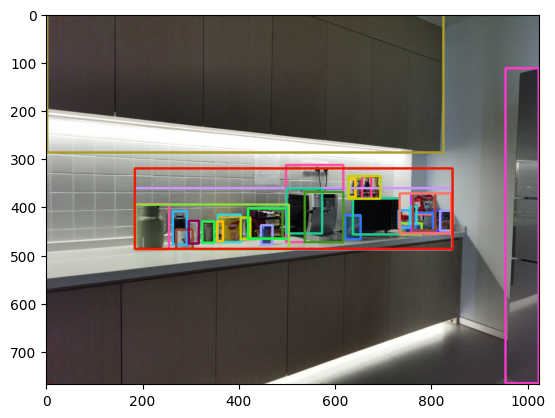

In [ ]:
sys.path.append("/root/svid/GroundingDINO-main")
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model

CONFIG_PATH = "/root/svid/GroundingDINO-main/groundingdino/config/GroundingDINO_SwinT_OGC.py"
CHECKPOINT_PATH = "/root/svid/GroundingDINO-main/weights/groundingdino_swint_ogc.pth"
DEVICE = "cuda"
TEXT_PROMPT = "Objects"
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.25
FP16_INFERENCE = False

image_source, image = load_image(demo_path)
height, width, channel = image_source.shape
model_groundingdino = load_model(CONFIG_PATH, CHECKPOINT_PATH)

if FP16_INFERENCE:
    image = image.half()
    model_groundingdino = model_groundingdino.half()

boxes, logits, phrases = predict(
    model=model_groundingdino,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE,
)

boxes_cxcywh = boxes * torch.Tensor([width, height, width, height])
xyxy = box_convert(boxes=boxes_cxcywh, in_fmt="cxcywh", out_fmt="xyxy").numpy()
detections = sv.Detections(xyxy=xyxy)

box_annotator = sv.BoxAnnotator(thickness=30)
annotated_frame = image_source.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections, labels=None, skip_label=True)

plt.imshow(annotated_frame)

  2. Crop detected proposals

In [ ]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

os.makedirs(os.path.join(output_dir, 'roi_1_square_mask', test_demo.split('.jpg')[0]), exist_ok=True)

image = Image.open(demo_path)

bboxes = []
for box in boxes.tolist():
    bboxes.append([box[0]*width - box[2]*width // 2,
                   box[1]*height - box[3]*height // 2,
                   box[2]*width, box[3]*height])
scores = logits.tolist()

if os.path.exists(os.path.join(output_dir, 'proposals_on_roi_1_square_mask.json')):
    with open(os.path.join(output_dir, 'proposals_on_roi_1_square_mask.json'), 'r') as f:
        rois = json.load(f)

else:
    rois = {test_demo.split('.jpg')[0]:[]}
    for idx, box in enumerate(bboxes):
        # bbox
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[0] + box[2])
        y1 = int(box[1] + box[3])

        # crop and save roi
        roi = image.crop((x0, y0, x1, y1))
        roi_pad = expand2square(roi, (255, 255, 255))
        roi_pad.save(os.path.join(output_dir, 'roi_1_square_mask', test_demo.split('.jpg')[0], 'test_1_' + str(idx).zfill(3) + '_square.png'))
    
        # save bbox
        roi = dict()
        roi['roi_id'] = int(idx)
        roi['image_id'] = demo_id
        roi['category_id'] = 0
        roi['bbox'] = box
        roi['score'] = scores[idx]
        roi['roi_dir'] = os.path.join(os.path.join(output_dir, 'roi_1_square_mask', test_demo.split('.jpg')[0], 'test_1_' + str(idx).zfill(3) + '_square.png'))
        roi['image_dir'] = demo_path
        roi['image_width'] = width
        roi['image_height'] = height
        roi['scale'] = 1
        rois[test_demo.split('.jpg')[0]].append(roi)    

    with open(os.path.join(output_dir, 'proposals_on_roi_1_square_mask.json'), 'w') as f:
        json.dump(rois, f)

  3. Extract features from objects' visual references and detected proposals, predict detection through feature matching

In [14]:
# # ============ Preparing Test dataset ============
# Object
obj_dataset = InsDetDataset_v4(object_dir,
                               "Object",
                               transform=[transform],
                               imsize=imsize)

# Render views
test_render_dataset = InsDetDataset_v4(render_dir,
                                       "Object", 
                                       transform=[transform], 
                                       imsize=imsize, 
                                       num_profiles=num_render)

# Scene
scene_dataset = InsDetDataset_v4(os.path.join(output_dir, 'roi_1_square_mask'),
                                 "Scene",
                                 transform=[transform],
                                 imsize=imsize)

level = "" # 'easy', 'hard'
split_idx = [0, len(scene_dataset.cfg['scene_name'])]

score_thresh_predefined = [0.4, 0.4] # for visualization [0.5]
score_thresh = score_thresh_predefined[-1]

# # ============ Testing ============
print(f"==================== Testing ====================")
num_object = len(obj_dataset.cfg['obj_name'])
num_example = len(obj_dataset.cfg['image_dir']) // num_object
num_example += len(test_render_dataset.cfg['image_dir']) // num_object
logger.info("Testing data: num_object={}, num_example={}".format(num_object, num_example))

trainer = TrainerWithTriplet(train_args, model_dinov2, obj_dataset, scene_dataset, bg_dataset=None,
                             render_dataset=test_render_dataset, num_workers=4)


# # testing --> save object_features and scene_features --> save detection results
print(f"Start testing...")
epoch = 1

output_path = os.path.join(cache_dir, f"output_features_epoch{epoch}.json")
if os.path.exists(output_path):
    with open(output_path, 'r') as f:
        output_features = json.load(f)
    object_features = torch.Tensor(output_features['object_features'])
    scene_features = torch.Tensor(output_features['scene_features'])
else:
    weight_path = ckpt_dir + '/epoch' + str(epoch) + '.pt'
    print(f"Loading weights from {weight_path}...")
    trainer.load_weights(weight_path)
    object_features, scene_features = trainer.eval()
    
    output_features = {'object_features': object_features.detach().cpu().tolist(),
                       'scene_features': scene_features.detach().cpu().tolist()}
    with open(output_path, 'w') as f:
        json.dump(output_features, f)
            
results = eval(output_dir, level, epoch, object_features, num_object,
               num_example, scene_features, scene_dataset, split_idx, 
               score_thresh_predefined, score_thresh)

# ============ save final results ============
with open(os.path.join(output_dir, "coco_instances_results{}_epoch{}.json".format(str(level), str(epoch))), "w") as f:
    json.dump(results, f)

predictions = dict(
        [(k, {'image_id': -1, 'instances': []}) for k in [demo_id]])
for idx in range(len(results)):
    id = results[idx]['image_id']
    predictions[id]['image_id'] = id

    predictions[id]['instances'].append(results[idx])

torch.save(predictions, os.path.join(output_dir, f"instances_predictions{level}_epoch{epoch}.pth"))

==================== Testing ====================
Start testing...
Loading weights from /root/svid/dinov2-main/demo_IDOW/torch_checkpoints_InsDet/IDOW_GroundingDINO_DINOv2_InsDet/epoch1.pt...
computing object features!!
object_feat1:  2400
computing rendered features!!
object_feat:  7200
computing proposal features!!
proposal_feat:  39


  4. Visualization on predicted detection

[10, 11, 12, 18, 3, 9, 6, 2, 1, 4, 5, 14, 16, 13, 8, 7, 0]


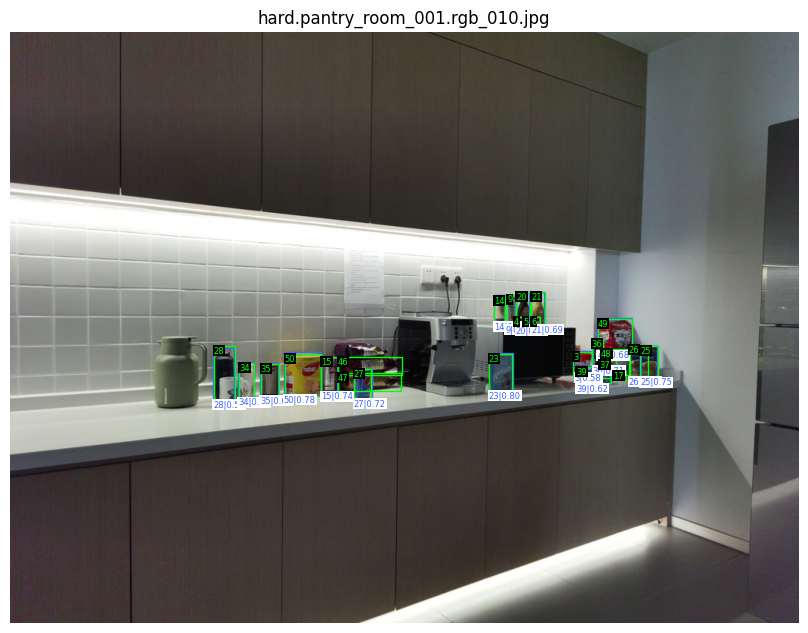

In [ ]:
from visualization import batched_nms, imshow_gt_det_bboxes
# # ============ Visualization ============
result_dir = os.path.join(output_dir, "instances_predictions{}_epoch{}.pth".format(str(level), str(epoch)))
sel_list = [test_demo] # select a testing image for visualization

# ========== Load GT annotations ==========
gt_metadata = dict([(k, {'image_id': -1, 'instances': []}) for k in range(len(gt_json['images']))])
for idx, anno in enumerate(gt_json['annotations']):
    id = anno['image_id']
    gt_metadata[id]['image_id'] = id
    gt_metadata[id]['instances'].append(anno)

# CLASSES = [d['name'] for d in gt_json['categories']]
CLASSES = [str(d['id']) for d in gt_json['categories']]
    

# ========== Load Predictions for Visualization ==========
save_dir = os.path.join(os.path.dirname(result_dir), 'show_results')
os.makedirs(save_dir, exist_ok=True)
results = torch.load(result_dir)

for idx,d in enumerate(gt_json['images']):

    if d['file_name'] not in sel_list:
        continue

    file_path = os.path.join(data_dir, d['file_name'])
    image_id = d['id']
    img = mmcv.imread(file_path)
    y,x = img.shape[:2]
    
    # GT annotations
    annotations = {}
    annotations['gt_bboxes'] = np.vstack([[anno['bbox'][0], anno['bbox'][1],
                                           anno['bbox'][0] + anno['bbox'][2],
                                           anno['bbox'][1] + anno['bbox'][3]] for anno in gt_metadata[image_id]['instances']])
    annotations['gt_labels'] = np.array([anno['category_id'] for anno in gt_metadata[image_id]['instances']], dtype=np.int32)

    # Predictions
    predictions = {}
    predictions['bboxes'] = np.vstack([[anno['bbox'][0], anno['bbox'][1],
                                        anno['bbox'][0] + anno['bbox'][2],
                                        anno['bbox'][1] + anno['bbox'][3],
                                        anno['score']] for anno in results[image_id]['instances']])
    predictions['labels'] = np.array([anno['category_id'] for anno in results[image_id]['instances']], dtype=np.int32)

    # Apply NMS
    iou_thresh = 0.0
    keep = batched_nms(torch.Tensor(predictions['bboxes'][:,:-1]),
                       torch.Tensor(predictions['bboxes'][:,-1]), 
                       torch.Tensor(predictions['labels']), iou_thresh)
    ids = [idx for idx, i in enumerate(list(predictions['labels'])) if i in list(annotations['gt_labels'])]
    keep_id = [i for i in keep.tolist() if i in ids]    

    predictions['bboxes'] = predictions['bboxes'][keep_id]
    predictions['labels'] = predictions['labels'][keep_id]
    
    imshow_gt_det_bboxes(img,
                         annotations,
                         predictions,
                         class_names=CLASSES,
                         score_thr=0.0,
                         thickness=15,
                         font_size=50,
                         win_name=test_demo,
                         fig_size=(x / 100, y / 100),
                         show=True,
                         wait_time=0,
                         out_file=os.path.join(save_dir, d['file_name']))